In [3]:
from tqdm import tqdm
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

In [4]:
features = pd.read_parquet('features.parquet')

In [5]:
drop_clmns = ['property_location',
'parcel_number',
'lot',
'current_sales_date',
'assessed_fixtures_value',
'assessed_improvement_value',
'assessed_land_value',
'assessed_personal_property_value',
'the_geom',
'sqft_price',
'home_price']

#     'property_location': 'object',  # part of UID
#     'parcel_number': 'object',  # part of UID
#     'block': 'object',  # part of UID
#     'lot': 'object',  # part of UID

features['idx'] = (
    features.property_location +
    features.parcel_number +
    features.block  +
    features.lot +
    features.week_number.astype('str')
)
features.set_index('idx', inplace=True)
main_feats = pd.read_csv('main_feats.csv').cols.iloc[:50]
data = features.drop(columns=drop_clmns).loc[:, main_feats]

target = features['home_price'] / features.home_price_lag1_roll26_rolling_median
target_sq = features['sqft_price'] / features.sqft_price_lag1_roll26_rolling_median

In [6]:
target_mask = (target_sq > target_sq.quantile(0.05)) & ( target_sq < target_sq.quantile(0.95))
week_mask = data.week_number > 51

data = data.loc[target_mask & week_mask]
target_sq = target_sq.loc[target_mask & week_mask]

In [7]:
cats = [name for name, type_ in data.dtypes.iteritems() if type_ == 'object']
for cat in cats:
    data[cat] = data[cat].astype('category')

cats = [name for name, type_ in data.dtypes.iteritems() if type_ == 'category']
for cat in cats:
    data[cat] = data[cat].cat.codes
data = data.fillna(-999)

In [8]:
years, week_step = 5, 4

start = 51
end = start + 52*years
number_of_steps = (data.week_number.max() - end)//4

In [9]:
week_number = data.week_number
data = data.drop(columns=['week_number','block'])

In [10]:
#Need to refactor this:
# NO FOR LOOPS!

class QGB:
    """
    Use LightGBM quantile regression.
    http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html
    http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html
    """

    def __init__(self, random_state=0, quantile_alphas = [.1, 0.3, .5, 0.7, .9]):
        params = {
            'objective': 'quantile',
            'metric': 'quantile',
        }
        self.quantile_alphas = quantile_alphas
        self.model = {}
        for quantile_alpha in self.quantile_alphas:
            # to train a quantile regression, we change the objective parameter and
            # specify the quantile value we're interested in
            key_ = "QGB_"+str(int(quantile_alpha*100))
            lgb = LGBMRegressor(
                objective='quantile',
                metric='quantile',
                max_depth= 4,
                num_leaves= 15,
                learning_rate= 0.1,
                n_estimators= 100,
                boosting_type= 'gbdt',
                alpha=quantile_alpha
                )
            self.model[key_] = lgb

        print("QGB initialized.")

    def fit(self, X, y):
        for model_key, lgb in self.model.items():
            lgb.fit(X, y)
            # print(f"QGB {model_key} trained.")

    def predict(self, X, quantile=None):
        preds = dict()
        for model_key, lgb in self.model.items():
            preds[model_key]=lgb.predict(X)
        
        return preds  # Probbaly need to concat here?!

    def finetune(self, X_train, y_train):
        """
        LightGBM quantile regression.
            # 'max_depth': 4,
            # 'num_leaves': 15,
            # 'learning_rate': 0.1,
            # 'n_estimators': 100,
            # 'boosting_type': 'gbdt'
        """

        def objective(trial):
            """
            Optuna methods for suggestions:
            suggest_categorical(name, choices)
                Suggest a value for the categorical parameter.
            suggest_discrete_uniform(name, low, high, q)
                Suggest a value for the discrete parameter.
            suggest_float(name, low, high, *[, step, log])
                Suggest a value for the floating point parameter.
            suggest_int(name, low, high[, step, log])
                Suggest a value for the integer parameter.
            suggest_loguniform(name, low, high)
                Suggest a value for the continuous parameter.
            suggest_uniform(name, low, high)
                Suggest a value for the continuous parameter.
            """
            self.cv_results = dict()
            max_depth = trial.suggest_int("max_depth", 4, 30)
            learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
            # n_estimators = trial.suggest_int("n_estimators", 10, 100)
            for quantile_alpha in self.quantile_alphas:
                # to train a quantile regression, we change the objective parameter and
                # specify the quantile value we're interested in
                model = LGBMRegressor(
                    objective='quantile', metric='quantile',
                    alpha=quantile_alpha, max_depth=max_depth,
                    learning_rate=learning_rate
                    # ,n_estimators=n_estimators
                    )
 
                self.cv_results[quantile_alpha] = cross_validate(model, X_train, y_train, cv=3)

            score = np.mean([
                          cv_results["test_score"].mean() for cv_results
                          in self.cv_results.values()
                          ])

            return score

        self.study = optuna.create_study(direction="minimize")
        self.study.optimize(objective, n_trials=20)
        self.best_params = self.study.best_trials[0].params
        print(f"Best Quantile score: {self.study.best_value}")

        # Look at self.study to get the best validation score
        for model_key, lgb in self.model.items():
            self.model[model_key] = LGBMRegressor(
                objective='quantile',
                metric='quantile',
                max_depth=self.best_params["max_depth"],
                learning_rate=self.best_params["learning_rate"])
                    # , n_estimators=self.best_params["n_estimators"]
    
            self.model[model_key].fit(X_train, y_train)
            # print(f"QGB {model_key} trained.")

        print("QGB finetuned and trained.")

In [14]:
qgb = QGB()

for i in tqdm(range(number_of_steps)):
    
    start = 51 + i*week_step
    end = start + 52*years + i*week_step
    
    train_week_mask = (week_number >= start) & (week_number < end)
    val_week_mask =  (week_number >= end) & (week_number < (end + week_step))
    train_x, val_x = data.loc[train_week_mask], data.loc[val_week_mask]
    train_y, val_y = target_sq.loc[train_week_mask], target_sq.loc[val_week_mask]
        
    if val_x.shape[0] > 0:

        qgb.fit(train_x, train_y)

        pred = qgb.predict(val_x)

        preds_df = pd.DataFrame(pred, index=val_x.index)
        preds_df.to_csv(f'data/qgb/qgb_{i}.csv')
        val_y.to_csv(f'data/target/target_{i}.csv')
        print(f"step {i} mape {np.mean(np.abs(((pred['QGB_50'] - val_y) / val_y)))}")

QGB initialized.


  1%|▉                                                                                  | 1/91 [00:01<02:06,  1.40s/it]

step 0 mape 0.16764122005504664


  2%|█▊                                                                                 | 2/91 [00:02<02:07,  1.43s/it]

step 1 mape 0.16307990860754323


  3%|██▋                                                                                | 3/91 [00:04<02:07,  1.44s/it]

step 2 mape 0.13944504365672908


  4%|███▋                                                                               | 4/91 [00:05<02:06,  1.45s/it]

step 3 mape 0.1453462373545989


  5%|████▌                                                                              | 5/91 [00:07<02:07,  1.48s/it]

step 4 mape 0.13326890441378603


  7%|█████▍                                                                             | 6/91 [00:08<02:10,  1.53s/it]

step 5 mape 0.1363241296673885


  8%|██████▍                                                                            | 7/91 [00:10<02:09,  1.54s/it]

step 6 mape 0.10960910900239743


  9%|███████▎                                                                           | 8/91 [00:12<02:09,  1.56s/it]

step 7 mape 0.1424132696422678


 10%|████████▏                                                                          | 9/91 [00:13<02:07,  1.56s/it]

step 8 mape 0.12875624817261463


 11%|█████████                                                                         | 10/91 [00:15<02:08,  1.59s/it]

step 9 mape 0.13711653972809415


 12%|█████████▉                                                                        | 11/91 [00:16<02:07,  1.60s/it]

step 10 mape 0.13701441009166918


 13%|██████████▊                                                                       | 12/91 [00:18<02:07,  1.62s/it]

step 11 mape 0.1528469444789649


 14%|███████████▋                                                                      | 13/91 [00:20<02:06,  1.62s/it]

step 12 mape 0.13498516482783868


 15%|████████████▌                                                                     | 14/91 [00:21<02:04,  1.62s/it]

step 13 mape 0.14404311102941575


 16%|█████████████▌                                                                    | 15/91 [00:23<02:07,  1.68s/it]

step 14 mape 0.13048279834711698


 18%|██████████████▍                                                                   | 16/91 [00:25<02:05,  1.68s/it]

step 15 mape 0.12875621481764443


 19%|███████████████▎                                                                  | 17/91 [00:27<02:06,  1.71s/it]

step 16 mape 0.135398418161462


 20%|████████████████▏                                                                 | 18/91 [00:29<02:12,  1.82s/it]

step 17 mape 0.13849696220387395


 21%|█████████████████                                                                 | 19/91 [00:30<02:10,  1.81s/it]

step 18 mape 0.13697067497956217


 22%|██████████████████                                                                | 20/91 [00:32<02:07,  1.79s/it]

step 19 mape 0.14289538200752314


 23%|██████████████████▉                                                               | 21/91 [00:34<02:07,  1.83s/it]

step 20 mape 0.130301845550845


 24%|███████████████████▊                                                              | 22/91 [00:36<02:05,  1.82s/it]

step 21 mape 0.13037229432520425


 25%|████████████████████▋                                                             | 23/91 [00:38<02:06,  1.86s/it]

step 22 mape 0.1387699987101072


 26%|█████████████████████▋                                                            | 24/91 [00:40<02:06,  1.88s/it]

step 23 mape 0.12303820256905817


 27%|██████████████████████▌                                                           | 25/91 [00:42<02:05,  1.90s/it]

step 24 mape 0.14858010408953273


 29%|███████████████████████▍                                                          | 26/91 [00:44<02:08,  1.98s/it]

step 25 mape 0.13609773519184445


 30%|████████████████████████▎                                                         | 27/91 [00:47<02:26,  2.29s/it]

step 26 mape 0.15369174633158222


 31%|█████████████████████████▏                                                        | 28/91 [00:50<02:32,  2.42s/it]

step 27 mape 0.12257841785608595


 32%|██████████████████████████▏                                                       | 29/91 [00:52<02:33,  2.47s/it]

step 28 mape 0.13014489840145063


 33%|███████████████████████████                                                       | 30/91 [00:54<02:23,  2.35s/it]

step 29 mape 0.1371690808039272


 34%|███████████████████████████▉                                                      | 31/91 [00:56<02:16,  2.27s/it]

step 30 mape 0.13849846128503648


 35%|████████████████████████████▊                                                     | 32/91 [00:59<02:16,  2.32s/it]

step 31 mape 0.12847119929375173


 36%|█████████████████████████████▋                                                    | 33/91 [01:01<02:15,  2.34s/it]

step 32 mape 0.12790474262171586


 37%|██████████████████████████████▋                                                   | 34/91 [01:03<02:08,  2.26s/it]

step 33 mape 0.13515420986389173


 38%|███████████████████████████████▌                                                  | 35/91 [01:05<02:03,  2.20s/it]

step 34 mape 0.12421765627069264


 40%|████████████████████████████████▍                                                 | 36/91 [01:08<02:00,  2.18s/it]

step 35 mape 0.12982418656035805


 41%|█████████████████████████████████▎                                                | 37/91 [01:10<01:57,  2.18s/it]

step 36 mape 0.11926146091566683


 42%|██████████████████████████████████▏                                               | 38/91 [01:12<01:52,  2.13s/it]

step 37 mape 0.14207200627457653


 43%|███████████████████████████████████▏                                              | 39/91 [01:14<01:55,  2.21s/it]

step 38 mape 0.13591284040521012


 44%|████████████████████████████████████                                              | 40/91 [01:16<01:53,  2.23s/it]

step 39 mape 0.12901127783169145


 45%|████████████████████████████████████▉                                             | 41/91 [01:19<01:54,  2.30s/it]

step 40 mape 0.14064282127724748


 46%|█████████████████████████████████████▊                                            | 42/91 [01:21<01:50,  2.26s/it]

step 41 mape 0.1468393774853582


 47%|██████████████████████████████████████▋                                           | 43/91 [01:23<01:48,  2.26s/it]

step 42 mape 0.15784500746897256


 48%|███████████████████████████████████████▋                                          | 44/91 [01:25<01:43,  2.21s/it]

step 43 mape 0.13011805603580756


 49%|████████████████████████████████████████▌                                         | 45/91 [01:28<01:41,  2.21s/it]

step 44 mape 0.12308118441976379


 55%|█████████████████████████████████████████████                                     | 50/91 [01:30<00:34,  1.18it/s]

step 45 mape 0.1326907458599087


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [01:31<00:00,  1.00s/it]


In [28]:
number_of_steps

91

<AxesSubplot:>

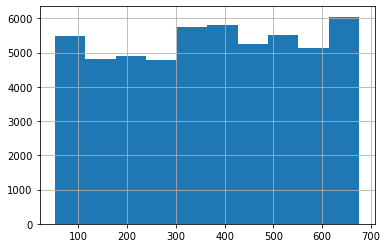

In [29]:
week_number.hist()